In [334]:
import pandas as pd
import os
from os.path import join
import pylab as plt

In [372]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'test_senario')

In [374]:
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))

<Axes: >

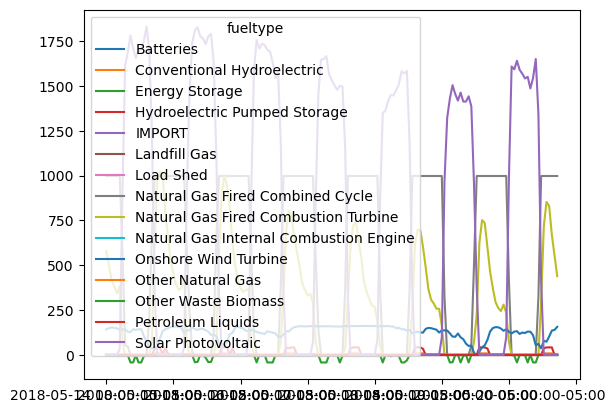

In [376]:
gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().T.plot()

In [378]:
grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped

,2018-05-14 00:00:00-05:00,2018-05-14 01:00:00-05:00,2018-05-14 02:00:00-05:00,2018-05-14 03:00:00-05:00,2018-05-14 04:00:00-05:00,2018-05-14 05:00:00-05:00,2018-05-14 06:00:00-05:00,2018-05-14 07:00:00-05:00,2018-05-14 08:00:00-05:00,2018-05-14 09:00:00-05:00,...,2018-05-20 15:00:00-05:00,2018-05-20 16:00:00-05:00,2018-05-20 17:00:00-05:00,2018-05-20 18:00:00-05:00,2018-05-20 19:00:00-05:00,2018-05-20 20:00:00-05:00,2018-05-20 21:00:00-05:00,2018-05-20 22:00:00-05:00,2018-05-20 23:00:00-05:00,2018-05-21 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Conventional Hydroelectric,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,8.9000,8.9000,8.9000,8.9000,0.0000,0.000
Energy Storage,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,-42.0000,...,-42.0000,-42.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Hydroelectric Pumped Storage,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,36.9600,42.0000,42.0000,42.0000,0.0000,0.000
IMPORT,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Landfill Gas,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Load Shed,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.00000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Natural Gas Fired Combined Cycle,998.0000,998.0000,998.0000,998.0000,998.0000,998.000000,579.02852,53.924157,47.05412,0.0000,...,0.0000,0.0000,324.778669,998.000000,998.0000,998.0000,998.0000,998.0000,998.0000,998.000
Natural Gas Fired Combustion Turbine,579.2827,496.8075,418.4806,381.3695,342.2235,384.085304,73.20000,0.000000,0.00000,0.0000,...,0.0000,0.0000,0.000000,296.400569,718.0014,853.2089,830.1938,669.4676,553.4875,439.260


In [380]:
gen.columns[20:40]

Index(['2018-05-14 20:00:00-05:00', '2018-05-14 21:00:00-05:00',
       '2018-05-14 22:00:00-05:00', '2018-05-14 23:00:00-05:00',
       '2018-05-15 00:00:00-05:00', '2018-05-15 01:00:00-05:00',
       '2018-05-15 02:00:00-05:00', '2018-05-15 03:00:00-05:00',
       '2018-05-15 04:00:00-05:00', '2018-05-15 05:00:00-05:00',
       '2018-05-15 06:00:00-05:00', '2018-05-15 07:00:00-05:00',
       '2018-05-15 08:00:00-05:00', '2018-05-15 09:00:00-05:00',
       '2018-05-15 10:00:00-05:00', '2018-05-15 11:00:00-05:00',
       '2018-05-15 12:00:00-05:00', '2018-05-15 13:00:00-05:00',
       '2018-05-15 14:00:00-05:00', '2018-05-15 15:00:00-05:00'],
      dtype='object')

In [382]:
prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

In [384]:
prices

,2018-05-14 00:00:00-05:00,2018-05-14 01:00:00-05:00,2018-05-14 02:00:00-05:00,2018-05-14 03:00:00-05:00,2018-05-14 04:00:00-05:00,2018-05-14 05:00:00-05:00,2018-05-14 06:00:00-05:00,2018-05-14 07:00:00-05:00,2018-05-14 08:00:00-05:00,2018-05-14 09:00:00-05:00,...,2018-05-20 15:00:00-05:00,2018-05-20 16:00:00-05:00,2018-05-20 17:00:00-05:00,2018-05-20 18:00:00-05:00,2018-05-20 19:00:00-05:00,2018-05-20 20:00:00-05:00,2018-05-20 21:00:00-05:00,2018-05-20 22:00:00-05:00,2018-05-20 23:00:00-05:00,2018-05-21 00:00:00-05:00
0,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
1,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
2,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
3,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
4,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
485,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
486,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844
487,14.548737,14.51215,14.509844,14.509844,14.486269,14.509844,12.495568,9.855475,9.855475,0.0,...,0.0,0.0,9.855475,14.486269,15.158472,15.158472,15.158472,15.158472,14.548737,14.509844


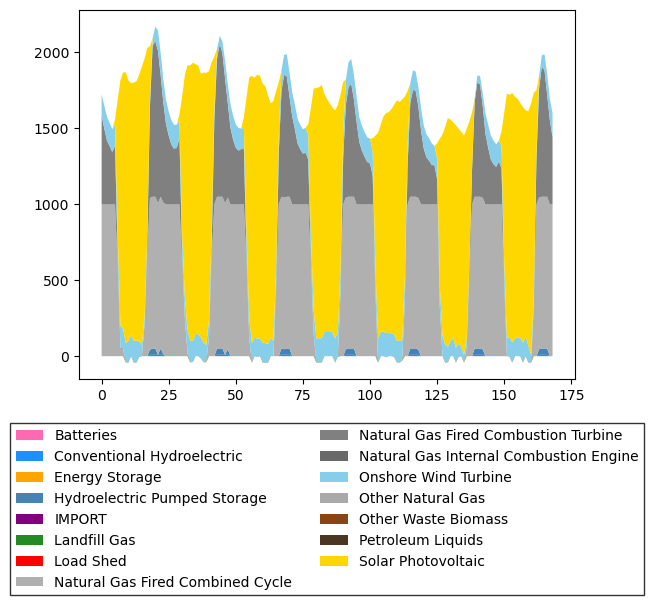

In [386]:
y = grouped.to_numpy()

fig, ax = plt.subplots()
plt.stackplot(range(len(y.T)), y, labels=grouped.index, colors=[i[1] for i in generator_colors]);
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=2, fancybox=False, edgecolor='k')

In [287]:
generator_colors = [
    ("Solar Photovoltaic", "#FFD700"),
    ("Energy Storage", "orange"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "#1E90FF"),
    ("Hydroelectric Pumped Storage", "#4682B4"),
    ("Natural Gas Fired Combined Cycle", "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine", "#808080"),
    ("Natural Gas Internal Combustion Engine", "#696969"),
    ("Other Natural Gas", "#A9A9A9"),
    ("Petroleum Liquids", "#4B3621"),
    ("Landfill Gas", "#228B22"),
    ("Other Waste Biomass", "#8B4513"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "#800080"),
    ("Load Shed", "#FF0000")
]
generator_colors.sort()

In [289]:
generator_colors

[('Batteries', '#FF69B4'),
 ('Conventional Hydroelectric', '#1E90FF'),
 ('Energy Storage', 'orange'),
 ('Hydroelectric Pumped Storage', '#4682B4'),
 ('IMPORT', '#800080'),
 ('Landfill Gas', '#228B22'),
 ('Load Shed', '#FF0000'),
 ('Natural Gas Fired Combined Cycle', '#B0B0B0'),
 ('Natural Gas Fired Combustion Turbine', '#808080'),
 ('Natural Gas Internal Combustion Engine', '#696969'),
 ('Onshore Wind Turbine', '#87CEEB'),
 ('Other Natural Gas', '#A9A9A9'),
 ('Other Waste Biomass', '#8B4513'),
 ('Petroleum Liquids', '#4B3621'),
 ('Solar Photovoltaic', '#FFD700')]

In [368]:
soc = pd.read_csv(join(outputs_dir, 'soc.csv'))

<Axes: >

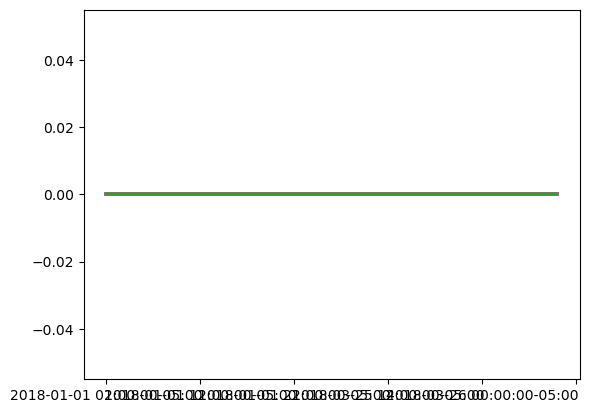

In [370]:
soc.T.iloc[0:-3,:].plot(legend=False)

<Axes: >

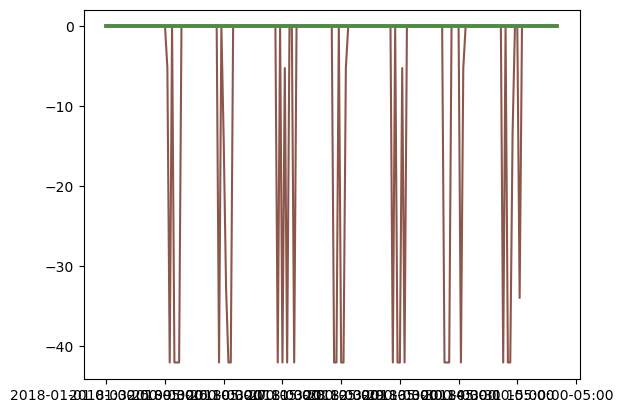

In [324]:
gen[gen['fueltype'] == "Energy Storage"].iloc[:,0:-3].T.plot(legend=False)

<Axes: >

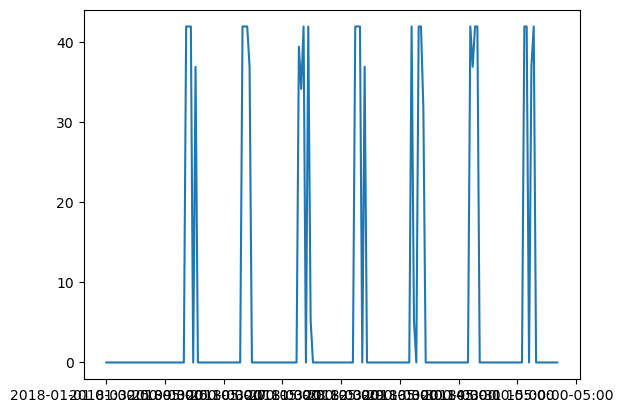

In [326]:
gen[gen['fueltype'] == "Hydroelectric Pumped Storage"].iloc[:,0:-3].T.plot(legend=False)

In [254]:
gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,IMPORT
1,1.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,1.4,1.4,1.4,1.4,1.4,1.4,1.4,2,7,Conventional Hydroelectric
2,60.5,60.5,60.5,60.5,60.5,60.5,60.500000,60.500000,60.50000,60.500000,...,60.5,60.5,60.5,60.5,60.5,60.5,60.5,3,12,Natural Gas Fired Combustion Turbine
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
4,0.0,0.0,0.0,0.0,0.0,0.0,0.417614,12.987787,20.37955,20.296027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,13,Solar Photovoltaic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [258]:
battery_gen = gen[gen['gen_id'].isin(soc['gen_id'])]

In [260]:
battery_gen[(battery_gen.drop(columns=['bus']).set_index(['gen_id', 'fueltype']).sum(axis=1) != 0).values]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype


In [301]:
soc[(soc.iloc[:, 20] != 0)]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.74,40.74,81.48,...,129.896907,129.896907,86.597938,86.597938,43.298969,43.298969,0.0,39,100,Hydroelectric Pumped Storage


In [264]:
battery_gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,43,Batteries
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,47,Batteries
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,54,Batteries
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,60,Batteries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [299]:
[gen[gen["fueltype"] == "Energy Storage"].iloc[:, i].min() for i in range(24)]

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -42.0,
 -0.0,
 -42.0,
 -0.0,
 -5.1958762886598,
 -0.0,
 -42.0,
 -42.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0]

In [268]:
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Conventional Hydroelectric,8.9000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,8.9000,8.9000,8.9000,8.9000,8.9000,8.9000,8.900
Energy Storage,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Hydroelectric Pumped Storage,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
IMPORT,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Landfill Gas,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Load Shed,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
Natural Gas Fired Combined Cycle,998.0000,998.0000,998.000,998.0000,998.0000,998.0000,998.000000,998.000000,998.000000,998.000000,...,995.481739,998.000000,998.0000,998.0000,998.0000,998.0000,998.0000,998.0000,998.0000,998.000
Natural Gas Fired Combustion Turbine,610.4039,549.0049,546.656,510.1198,496.3646,523.5261,574.847853,382.868393,242.042923,184.807614,...,73.200000,365.725943,598.7458,856.2557,1010.8436,983.4989,955.2994,908.5568,809.2756,678.242
